In [1]:
# Load in needed libraries and code

import os
import json
import numpy as np
import torch as th
import motornet as mn
import pickle
import matplotlib.pyplot as plt

from my_policy import Policy  # the RNN
from my_task import CentreOutFF  # the task
from my_loss import cal_loss  # the loss function
from my_utils import (
    save_model,
    print_losses,
    plot_stuff,
    run_episode,
    test,
    plot_training_log,
    plot_simulations,
    plot_activation,
    plot_kinematics,
)  # utility functions
print("All packages imported.")
print("pytorch version: " + th.__version__)
print("numpy version: " + np.__version__)
print("motornet version: " + mn.__version__)

All packages imported.
pytorch version: 2.7.1
numpy version: 2.2.4
motornet version: 0.2.0


In [2]:
# load up one of the trained models

model_name = "m1"
data = test(
        "models/" + model_name + "/" + "cfg.json",
        "models/" + model_name + "/" + "weights",
    )[0]
print(data.keys())

dict_keys(['xy', 'obs', 'tg', 'vel', 'all_actions', 'all_hidden', 'all_muscle', 'all_force'])


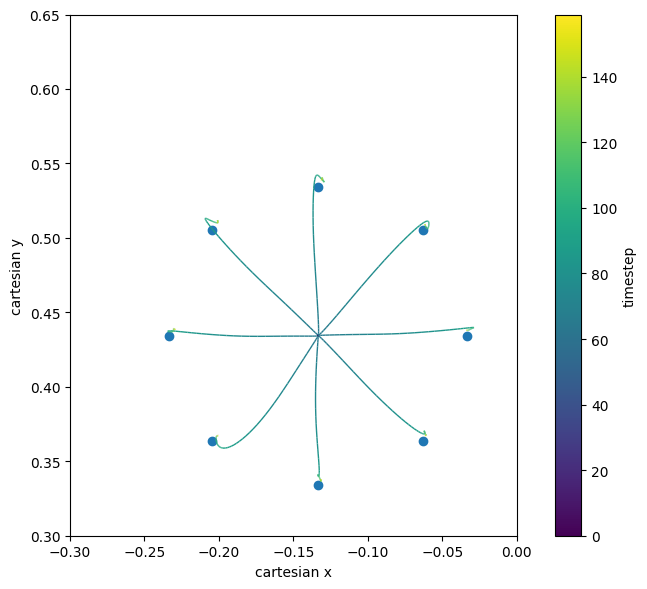

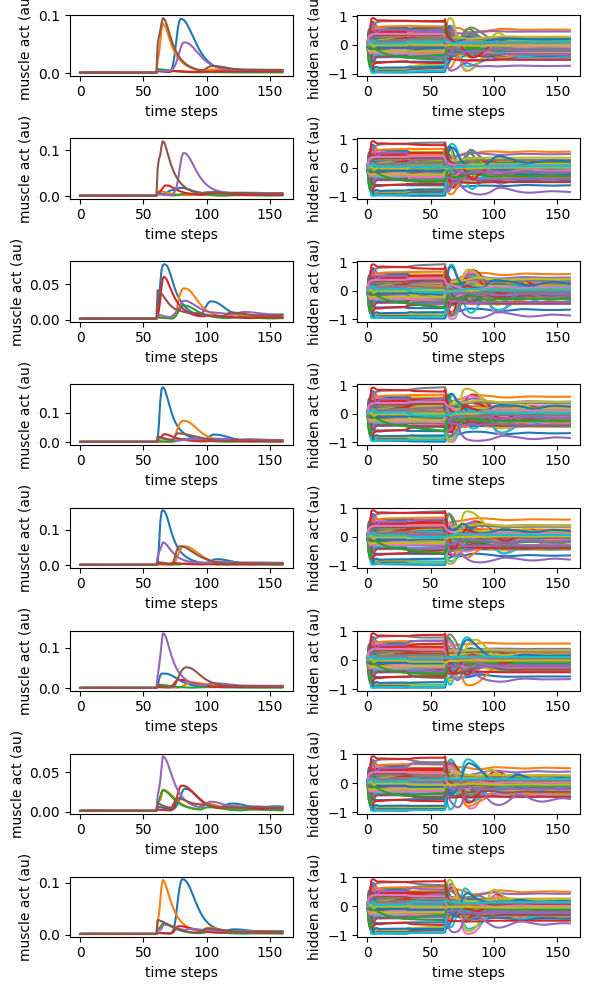

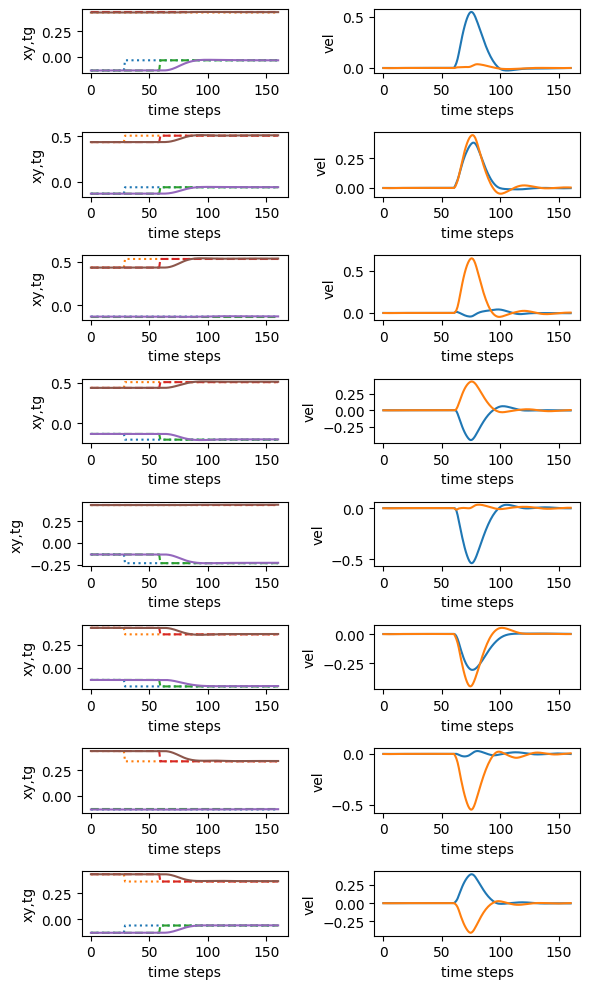

In [3]:
# generate some plots of hand paths, muscle activations & network activity, and joint kinematics

fig, ax = plot_simulations(xy=data["xy"], target_xy=data["tg"], figsize=(8, 6))
fig, ax = plot_activation(data["all_hidden"], data["all_muscle"])
fig, ax = plot_kinematics(all_xy=data["xy"], all_tg=data["tg"], all_vel=data["vel"], all_obs=data["obs"])

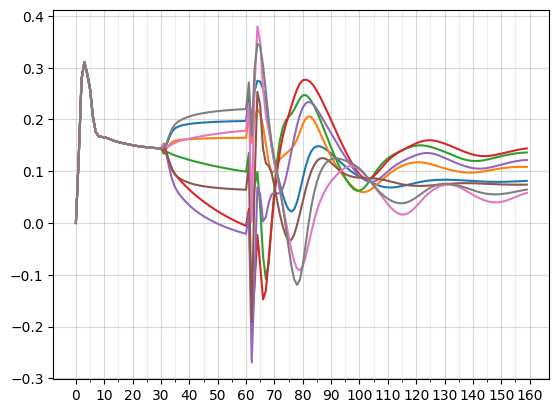

In [4]:
# plot hidden unit activity of one unit for the 8 center-out targets

h = data["all_hidden"][:,:,1].T # [tgt,time,neuron]
n_time = np.shape(h)[0]
time = np.arange(0,n_time,1)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(time,h)
major_ticks = np.arange(0, 161, 10)
minor_ticks = np.arange(0, 161, 5)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
plt.show()

/var/folders/qv/vfnlnw394w51jjx0s2p4sm1m0000gn/T/ipykernel_65054/1426429320.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  hh = h - np.tile(h0,[n_time,1])


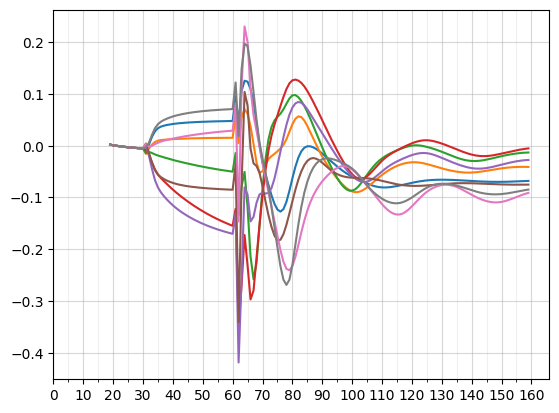

In [5]:
# chop off some of the initial drifting activity that starts at time zero

n_tgt = 24 # 1 timestep before the target shifts
n_win = 5
h0 = th.mean(h[n_tgt-n_win:n_tgt,:], axis=0) # mean hidden activity over n_win timesteps up to tgt shift
hh = h - np.tile(h0,[n_time,1])
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(time[n_tgt-n_win:], hh[n_tgt-n_win:])
major_ticks = np.arange(0, 161, 10)
minor_ticks = np.arange(0, 161, 5)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
plt.show()

In [6]:
# import the dPCA library so we can use it to analyse the population of hidden unit activity

from dPCA.dPCA import dPCA

In [7]:
# organize the data into handpaths, targets, and hidden unit activity

xy = data['xy'].detach().numpy()
tg = data['tg'].detach().numpy()
hid = data['all_hidden'].detach().numpy()

n_tgt, n_time, n_neuron = hid.shape
print(f"xy: {np.shape(xy)}")
print(f"tg: {np.shape(tg)}")
print(f"hid: {np.shape(hid)}")
print(f"hidden activity shape: {n_tgt} tgts, {n_time} time points, {n_neuron} neurons")


xy: (8, 160, 2)
tg: (8, 160, 2)
hid: (8, 160, 100)
hidden activity shape: 8 tgts, 160 time points, 100 neurons


In [8]:
# zero hidden activity to just prior to the tgt cue
go_cue = 30 # time step of go cue
for n in range(n_neuron):
    for t in range(n_tgt):
        hid[t,:,n] = hid[t,:,n] - hid[t,go_cue-1,n]

# chop off activity prior to the tgt cue
hid = hid[:, go_cue-25:, :]
n_tgt, n_time, n_neuron = hid.shape
print(f"hidden activity shape: {n_tgt} tgts, {n_time} time points, {n_neuron} neurons")

hidden activity shape: 8 tgts, 155 time points, 100 neurons


In [9]:
# compute the angle of each of the 8 targets from the movement origin (center target)

yy = tg[:, -1, 1] - xy[:, 0, 1]
xx = tg[:, -1, 0] - xy[:, 0, 0]
angles = np.mod(np.arctan2(yy, xx) + 2*np.pi, 2*np.pi)
print(f"tgt angles: {np.round(angles*180/np.pi)} degrees")

tgt angles: [  0.  45.  90. 135. 180. 225. 270. 315.] degrees


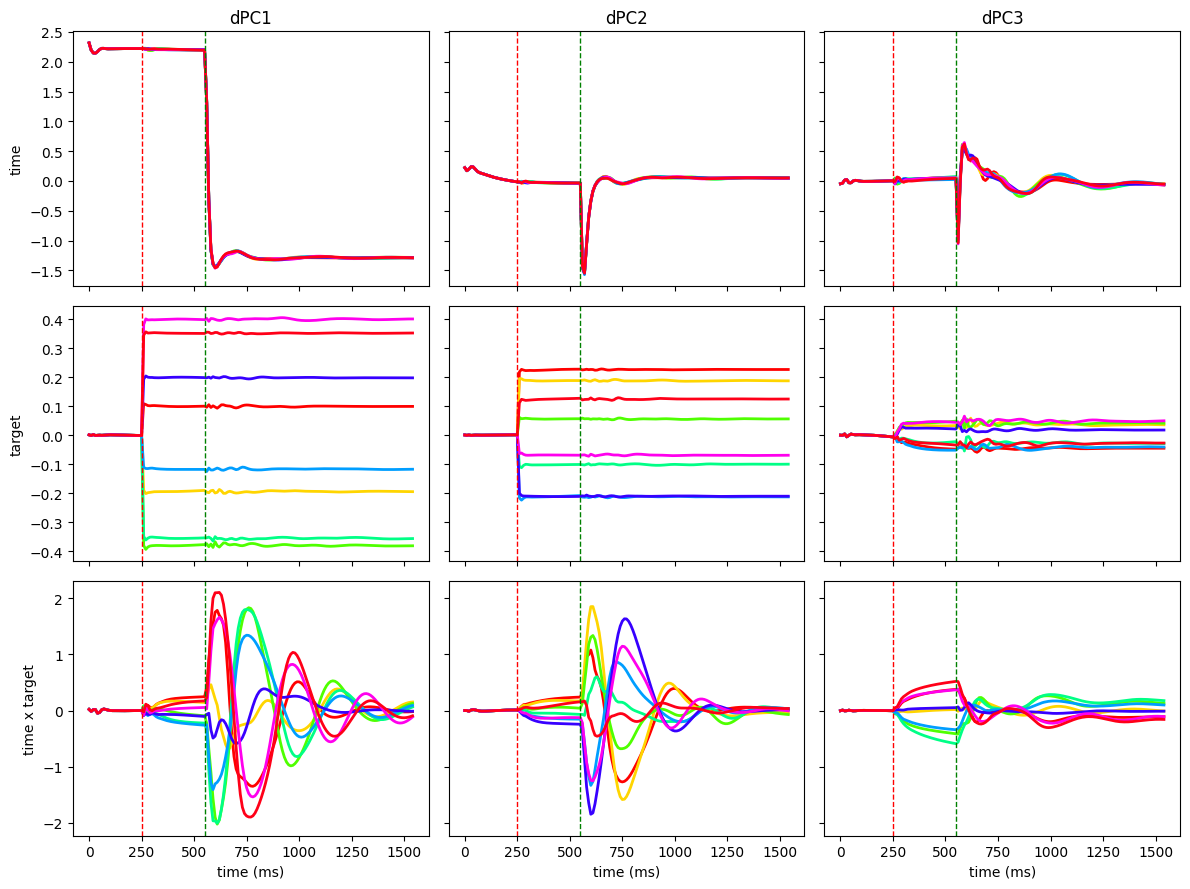

In [10]:
# perform a dPCA on the hidden unit activity
# using time points and target angles as labels

n_components = 3 # extract 3 dPCs
dpca = dPCA(labels='ta', n_components=n_components)
hid2 = hid.transpose(2,1,0)
hid_new = dpca.fit_transform(hid2)

legend = {k: k for k in hid_new.keys()}
legend['t'] = "time"
legend['a'] = "target"
legend['ta'] = "time x target"
dt = 10 # ms
tgtcue = 250 # ms
gocue  = 550 # ms
x = np.arange(0, n_time * dt, step=dt)
cm = plt.cm.hsv(np.linspace(0, 1, n_tgt))

fig, axs = plt.subplots(len(hid_new), n_components, sharey='row', sharex='col')
fig.set_tight_layout(True)
fig.set_size_inches((4 * n_components, 3 * len(hid_new)))

for i, (k, v) in enumerate(hid_new.items()):
  for j in range(n_components):
    axs[i, j].set_prop_cycle('color', list(cm))
    axs[i, j].plot(x, v[j, :, :], linewidth=2)
    axs[i, j].axvline(tgtcue, c='red', linewidth=1, linestyle='--')
    axs[i, j].axvline(gocue, c='green', linewidth=1, linestyle='--')

    if i == 0:
      axs[i, j].set_title("dPC" + str(j+1))
    if j == 0:
      axs[i, j].set_ylabel(legend[k])
    if i == len(legend)-1:
      axs[i, j].set_xlabel("time (ms)")

plt.show()


In [11]:
for (k,v) in hid_new.items():
    print(f"{k}: {np.shape(v)}")

t: (3, 155, 8)
a: (3, 155, 8)
ta: (3, 155, 8)


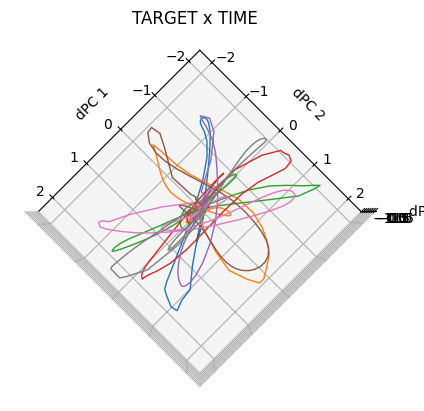

In [12]:
# plot dPC trajectories for each of the 8 targets in 3D
# using the time x target interaction effect

h = hid_new['ta']
ax = plt.figure().add_subplot(projection='3d')
for i_tgt in range(n_tgt):
    ax.plot(h[0,:,i_tgt].T, h[1,:,i_tgt].T, h[2,:,i_tgt].T, lw=1.0)
ax.set_xlabel("dPC 1")
ax.set_ylabel("dPC 2")
ax.set_zlabel("dPC 3")
ax.view_init(elev=90., azim=45, roll=0)
ax.axis('equal')
ax.set_title("TARGET x TIME")
plt.show()

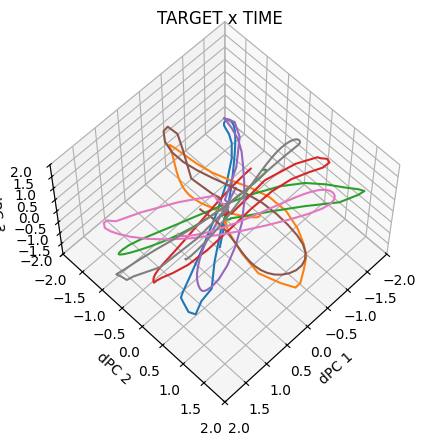

In [13]:
# make it into a movie

from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

# Example data (replace with your actual data)
n_tgt = 8
n_time = 100
h = hid_new['ta']

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel("dPC 1")
ax.set_ylabel("dPC 2")
ax.set_zlabel("dPC 3")
ax.view_init(elev=60., azim=45, roll=0)
ax.set_title("TARGET x TIME")
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_zlim([-2, 2])

# Initialize lines for each target
lines = [ax.plot([], [], [])[0] for _ in range(n_tgt)]

def init():
    for line in lines:
        line.set_data([], [])
        line.set_3d_properties([])
    return lines

def update(i):
    for i_tgt, line in enumerate(lines):
        line.set_data(h[0, :i, i_tgt], h[1, :i, i_tgt])
        line.set_3d_properties(h[2, :i, i_tgt])
    return lines

ani = FuncAnimation(fig, update, frames=n_time, init_func=init, interval=100, blit=True, repeat=False)

html_video = ani.to_html5_video()
HTML(html_video)

